# Word2Vec model

**(a) Train a text classifier using the following document representation techniques using 100-dimensional word vectors and report accuracy, macro-f1 score, and micro-f1 score on the test set. Compare and analyze their performance.**

1. **Using publicly available pre-trained GloVe embeddings** as word vectors, a document vector is represented as an average of word vectors of its constituent words.
2. **Train Word2Vec** (e.g., use the `gensim` package) on AGNews text data and use them as word vectors to compute document vectors by averaging word vectors of its constituent words.
3. **Train Word2Vec on NYT text data** and use them as word vectors to compute document vectors by averaging word vectors of its constituent words.


**(b) What are the disadvantages of averaging word vectors for the document representation? Describe an idea to overcome this.**

The document vectors should be formed using word vectors.  
*Note: This is an open-ended question. Feel free to propose new ideas.*


In [3]:
# import necessary library 
import re
import gensim
import warnings

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from pprint import pprint
from scipy import sparse
from collections import defaultdict, Counter

from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# custom visualisation styling
custom = {"axes.edgecolor": "red", "grid.linestyle": "dashed", "grid.color": "black"}
sns.set_style("darkgrid", rc=custom)

warnings.simplefilter("ignore")

In [4]:
# load NYT dataset
data = pd.read_csv("nyt.csv")
print(data.shape)

(11519, 2)


Index(['text', 'label'], dtype='object')


<Axes: xlabel='label', ylabel='count'>

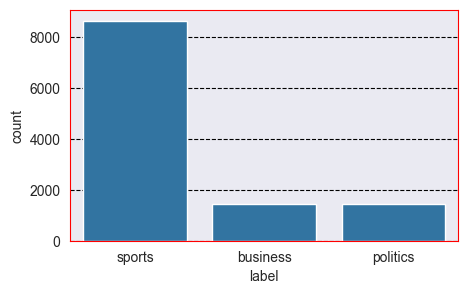

In [5]:
# check available columns
df = data.copy()
print(df.columns)

plt.figure(figsize=(5,3))
sns.countplot(data=df, x='label')

In [4]:
# convert the target variable data type from string to numeric
mapped_classes = df.label.astype('category')
hm_class = dict(enumerate(mapped_classes.cat.categories))
print(hm_class)

df['label'] = df.label.astype('category').cat.codes

{0: 'business', 1: 'politics', 2: 'sports'}


## a1. Using GloVe Embeddings

In [5]:
# gloVe file path containing pre-trained word vectors
glove_file = '../pretrained-models/glove.6B/glove.6B.100d.txt'

# temporary file path to store the converted Word2Vec format vectors
tmp_file = get_tmpfile("test_word2vec.txt")

# convert the gloVe file to word2vec format and save it to the temporary file
_ = glove2word2vec(glove_file, tmp_file)
model = KeyedVectors.load_word2vec_format(tmp_file)

In [6]:
# check embeddings of a random word
random_vec = model['random']
print(len(random_vec), '\n', random_vec)

100 
 [-0.34378   -0.13502   -0.43921    0.3171     0.45931    1.4118
  0.53641    1.072     -0.19217   -0.19073   -0.26035   -0.16939
  0.11266   -0.43995    0.15545    1.3412    -0.34172    0.94433
  0.062561   0.63704    0.5084    -0.4696     0.10751   -0.21524
  0.50907   -0.17371    0.94811    0.4571     0.40394   -0.12882
  0.50923   -0.058139  -0.55692   -0.51644    0.56536   -0.28991
 -0.081733  -0.1865     0.67905   -0.29877   -0.17778    0.42206
 -0.4408     0.2316    -0.95221    0.22149   -0.62444   -0.14468
 -0.37559   -0.4516     1.1225    -0.44304   -0.17111    0.058563
  0.44505   -1.2974     0.54388    0.49319    1.1714    -0.20397
  0.18537    0.11079    0.011758   0.33083    1.4132    -0.15832
  0.52176    0.050126   0.8741     0.16155   -0.99235   -0.034789
  0.43111    0.30439   -0.0060538 -0.10579    0.13443   -0.47229
 -1.179     -0.025391   0.97781    0.18939   -0.73967   -0.2017
 -0.84043   -0.017837   0.64232   -0.65417   -0.64107    0.27953
 -0.82348    1.0642

### Preprocessing

In [7]:
# required libraries from nltk for preprocessing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize, sent_tokenize

ps = PorterStemmer()
stop = set(stopwords.words('english'))

In [8]:
# common preprocessing function
def clean_text_and_tokenise(doc):
    # remove non-alpha numeric characters and strip off braces
    doc = re.sub(r'[^\w\s]', ' ', doc)
    doc = re.sub(r'[\{\}\[\]\(\)]', '', doc)
    
    # remove stopwords and apply stemming
    tokens = doc.lower().split(" ")
    tokens = [ps.stem(word) for word in tokens if word not in stop and 0 < len(word) < 16]
    return tokens

In [9]:
# helper functions - used from Prof. Jingbo's notebook
def get_avg_word_vector(doc, model):
    vecs = []
    doc_tokens = clean_text_and_tokenise(doc)
    
    for token in doc_tokens:
        try:
            vecs.append(model[token])
        except KeyError:
            pass
    return list(np.mean(vecs, axis=0))

In [10]:
# get average vector embeddings for each doc in dataset
df["glove_vector"] = df['text'].apply(lambda x: get_avg_word_vector(x, model))

### Modeling

#### Train-Test-Validation splits

In [11]:
# split training data into train(10%) and validation(10%)
train_ratio = 0.8
test_ratio = 0.1
validation_ratio = 0.1

def get_data_splits(df, col):
    # target
    Y = df["label"]
    df = df.drop(['label'], axis=1)

    # train test splits
    train_x, val_x, train_y, val_y = train_test_split(list(df[col]), Y, test_size=1-train_ratio, random_state=42)
    val_x, test_x, val_y, test_y = train_test_split(
        val_x, 
        val_y, 
        test_size=validation_ratio/(test_ratio + validation_ratio), 
        random_state=42
    )
        
    return train_x, val_x, test_x, train_y, val_y, test_y

In [12]:
# get splits across dataset
train_x, val_x, test_x, train_y, val_y, test_y = get_data_splits(df, col="glove_vector")

print(
    "train_data_size: {}%, validation_data_size: {}%, test_data_size: {}%".format(
    round(100 * len(train_x)/len(df), 4), 
    round(100 * len(val_x)/len(df), 4), 
    round(100 * len(test_x)/len(df), 4))
)

# concat train and val for predefined validation dataset
split_index = [-1]*len(train_x) + [0]*len(val_x)
X = np.concatenate((train_x, val_x), axis=0)
Y = np.concatenate((train_y, val_y), axis=0)

train_data_size: 79.9983%, validation_data_size: 10.0009%, test_data_size: 10.0009%


### Training

In [13]:
# logistic regression model using "one-vs-rest" strategy and Grid Search cross validation
# we have a predefined validation dataset
def get_best_LR(X, Y, split_index, param_grid):
    pds = PredefinedSplit(split_index)
    
    # hyperparameter tuning using grid search
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=pds, scoring='accuracy')
    grid_search.fit(X, Y)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params, "Best Accuracy on Validation set", best_score)
    return best_model

In [14]:
# hyperparameter space
param_grid = {
    'C': [0.001, 0.1, 1, 10, 100], # Regularization strength
    'max_iter': [100, 200, 500],  # Maximum iterations
    'penalty': ['l1', 'l2'], # Regularization
    'class_weight': [None, 'balanced']  # To handle class imbalance
}

model_glove = get_best_LR(X, Y, split_index, param_grid)

Best Parameters: {'C': 1, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2'} Best Accuracy on Validation set 0.9817708333333334


#### Inference on test data

In [15]:
def print_metrics(y, y_pred):
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Macro F1 Score:", f1_score(y, y_pred, average='macro'))
    print("Micro F1 Score:", f1_score(y, y_pred, average='micro'))

In [16]:
# infer using the best model on the test set
y_test_pred = model_glove.predict(test_x)

# calculate metrics on the test set
print_metrics(test_y, y_test_pred)

Accuracy: 0.9730902777777778
Macro F1 Score: 0.928047554460982
Micro F1 Score: 0.9730902777777778


In [17]:
# visualisation
# confusion matrix
def plot_confusion_matrix(test_y, y_test_pred):
    cm = confusion_matrix(test_y, y_test_pred)
    
    # create a heatmap using seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['business', 'politics', 'sports'],
                yticklabels=['business', 'politics', 'sports'])
    
    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

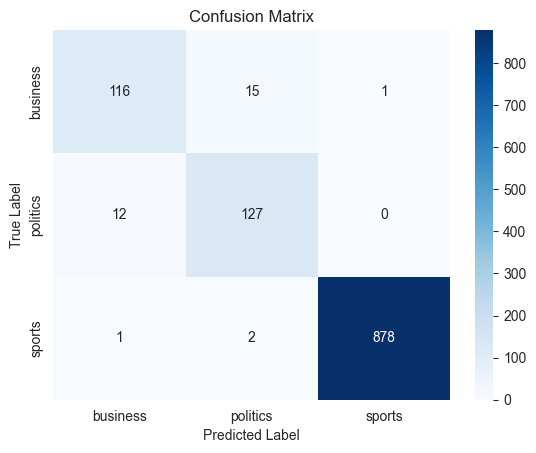

In [18]:
plot_confusion_matrix(test_y, y_test_pred)

## a2. Training a Word2Vec on AGNews

In [19]:
# AGNews Corpus
df_ag = pd.read_csv("ag.csv")
print(df_ag.shape)

(90000, 1)


In [20]:
# sample text
df_ag['text'][0]

"wall st. bears claw back into the black (reuters) . reuters - short-sellers, wall street's dwindling band of ultra-cynics, are seeing green again."

In [21]:
# curate input data for training the Word2Vec model, list of sentences
ag_news = list(df_ag['text'].apply(lambda x: clean_text_and_tokenise(x)))

### initialising model and params

In [22]:
from gensim.models import Word2Vec

# this will be a shallow deep learning model
wv_model = Word2Vec(
    sentences=ag_news,
    min_count=2, # ignores all words with a total frequency lower than this value.
    window=10, # model will consider the n words before and n words after that word as part of the context.
    negative=5, # k = the number of negative samples to use
    sg=1, # use Skip-Gram model.
    vector_size=100,
    workers=4
)

### building vocab

In [23]:
wv_model.build_vocab(ag_news, progress_per=10000)
print(wv_model.corpus_count)

90000


### word2vec model training

In [24]:
wv_model.train(
    ag_news, 
    total_examples=wv_model.corpus_count, 
    epochs=20, 
    start_alpha=0.04, 
    end_alpha=0.0001
)

(47616660, 49169920)

In [25]:
# normalize the word vectors and free up memory
wv_model.init_sims(replace=True)

### embeddings generation

In [26]:
# get average vector embeddings for each doc in dataset
df = data.copy()
df["wv_vector"] = df['text'].apply(lambda x: get_avg_word_vector(x, wv_model.wv))

In [27]:
# get splits across dataset
train_x, val_x, test_x, train_y, val_y, test_y = get_data_splits(df, col="wv_vector")

print(
    "train_data_size: {}%, validation_data_size: {}%, test_data_size: {}%".format(
    round(100 * len(train_x)/len(df), 4), 
    round(100 * len(val_x)/len(df), 4), 
    round(100 * len(test_x)/len(df), 4))
)

# concat train and val for predefined validation dataset
split_index = [-1]*len(train_x) + [0]*len(val_x)
X = np.concatenate((train_x, val_x), axis=0)
Y = np.concatenate((train_y, val_y), axis=0)

train_data_size: 79.9983%, validation_data_size: 10.0009%, test_data_size: 10.0009%


### train LR and inference

In [28]:
# train
model_lr_word2vec = get_best_LR(X, Y, split_index, param_grid)

Best Parameters: {'C': 100, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2'} Best Accuracy on Validation set 0.9765625


In [29]:
# infer using the best model on the test set
y_test_pred = model_lr_word2vec.predict(test_x)

# calculate metrics on the test set
print_metrics(test_y, y_test_pred)

Accuracy: 0.9748263888888888
Macro F1 Score: 0.9328064380832547
Micro F1 Score: 0.9748263888888888


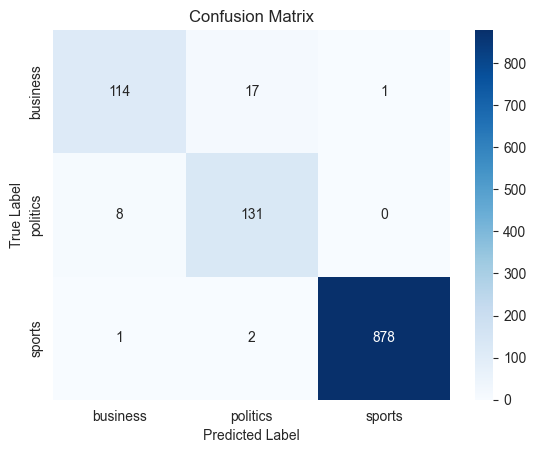

In [30]:
plot_confusion_matrix(test_y, y_test_pred)

## a3. Training a Word2Vec on NYU News dataset

In [31]:
# nyt data
nyt = data.copy()

# curate input data for training the Word2Vec model, list of sentences
nyt_news = list(df_ag['text'].apply(lambda x: clean_text_and_tokenise(x)))

### initialising model and params

In [32]:
# this will be a shallow deep learning model
wv_model_nyt = Word2Vec(
    sentences=nyt_news,
    min_count=2, # ignores all words with a total frequency lower than this value.
    window=7, # model will consider the n words before and n words after that word as part of the context.
    negative=5, # k = the number of negative samples to use
    sg=0, # use CBOW model.
    vector_size=100,
    workers=4
)

### building vocab

In [33]:
wv_model_nyt.build_vocab(nyt_news, progress_per=10000)
print(wv_model_nyt.corpus_count)

90000


### word2vec model training

In [34]:
wv_model_nyt.train(
    nyt_news, 
    total_examples=wv_model_nyt.corpus_count, 
    epochs=10,
    start_alpha=0.1, 
    end_alpha=0.0001
)

(23807317, 24584960)

In [35]:
# normalize the word vectors and free up memory
wv_model_nyt.init_sims(replace=True)

### embeddings generation

In [36]:
# get average vector embeddings for each doc in dataset
nyt["wv_vector"] = nyt['text'].apply(lambda x: get_avg_word_vector(x, wv_model_nyt.wv))

In [37]:
# get splits across dataset
train_x, val_x, test_x, train_y, val_y, test_y = get_data_splits(nyt, col="wv_vector")

print(
    "train_data_size: {}%, validation_data_size: {}%, test_data_size: {}%".format(
    round(100 * len(train_x)/len(df), 4), 
    round(100 * len(val_x)/len(df), 4), 
    round(100 * len(test_x)/len(df), 4))
)

# concat train and val for predefined validation dataset
split_index = [-1]*len(train_x) + [0]*len(val_x)
X = np.concatenate((train_x, val_x), axis=0)
Y = np.concatenate((train_y, val_y), axis=0)

train_data_size: 79.9983%, validation_data_size: 10.0009%, test_data_size: 10.0009%


### train LR and inference

In [38]:
# train
model_lr_word2vec = get_best_LR(X, Y, split_index, param_grid)

Best Parameters: {'C': 100, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2'} Best Accuracy on Validation set 0.9791666666666666


In [39]:
# infer using the best model on the test set
y_test_pred = model_lr_word2vec.predict(test_x)

# calculate metrics on the test set
print_metrics(test_y, y_test_pred)

Accuracy: 0.9756944444444444
Macro F1 Score: 0.9341127713859936
Micro F1 Score: 0.9756944444444444


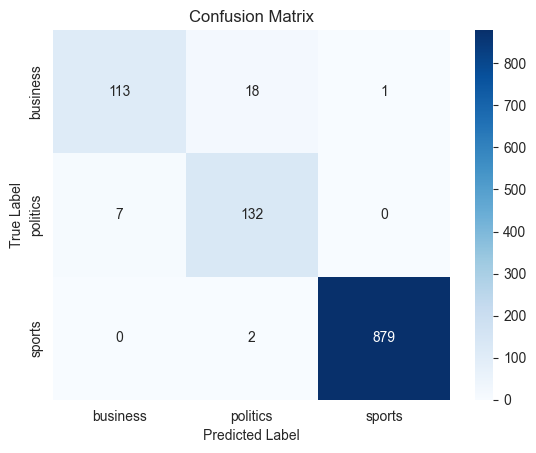

In [40]:
plot_confusion_matrix(test_y, y_test_pred)

## Question

**(b) What are the disadvantages of averaging word vectors for the document representation? Describe an idea to overcome this.**


**Disadvantages of average word vector representation**

The major disadvantage of averaging word vectors arises when polar words (eg "good", "bad") appear in the same document. Word2Vec models (**word2vec-google-news-300.model**) achieves the following cosine similarity values for different polar words:
* sim(**good, bad**) = 0.72
* sim(**bullish, bearish**) = 0.88
* sim(**long, short**) = 0.57

In tasks like sentiment analysis, this can lead to a loss of important information, as opposing sentiments (good, bad) may cancel each other out. Another example is automating stock trading using NLP, where financial losses could occur because words like "bullish" and "bearish" may be treated as similar, despite having opposite meanings.

**Mitigation Strategies**
1. We can use a more context aware representaion of words, such as advanced models like ELMo, Bert, which capture the meaning of words based on their context.
2. We can fine-tune or train word embeddings specifically for sentiment analysis or financial sentiment tasks, ensuring that words like "bullish" and "bearish" are assigned distinct vectors, even if they appear similar in general-purpose embeddings.